In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import shap
from scipy.optimize import minimize
from bayes_opt import BayesianOptimization

In [4]:
# Define stock tickers for Indian market
tickers = ['RELIANCE.NS', 'TCS.NS', 'INFY.NS', 'HDFCBANK.NS', 'ICICIBANK.NS']
data = yf.download(tickers, start='2020-01-01', end='2024-01-01')["Close"]
returns = data.pct_change().dropna()

[*********************100%***********************]  5 of 5 completed


In [5]:
print(data.head)

<bound method NDFrame.head of Ticker      HDFCBANK.NS  ICICIBANK.NS      INFY.NS  RELIANCE.NS       TCS.NS
Date                                                                        
2020-01-01  1227.428589    518.854004   655.615356   668.796692  2010.578979
2020-01-02  1235.252441    522.575623   653.702393   680.182495  2001.350098
2020-01-03  1217.636841    520.884033   663.756592   681.002075  2041.235229
2020-01-06  1191.285400    508.172424   657.394897   665.208069  2041.049072
2020-01-07  1210.149048    505.465820   647.652100   675.442078  2046.057983
...                 ...           ...          ...          ...          ...
2023-12-22  1648.341187    985.813293  1523.653564  1273.848755  3760.716553
2023-12-26  1659.784912    986.606445  1505.179443  1280.304810  3732.737793
2023-12-27  1680.354126    993.695496  1527.748169  1284.675049  3748.128418
2023-12-28  1682.277710    997.314331  1523.409912  1293.961792  3737.015381
2023-12-29  1686.223877    988.093689  1504.15

In [6]:
# Define portfolio optimization function
def portfolio_performance(weights, returns):
    weights = np.array(weights)
    port_return = np.sum(returns.mean() * weights) * 252
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe_ratio = port_return / port_volatility
    return sharpe_ratio


In [7]:
# Optimize portfolio using Bayesian Optimization
def optimize_portfolio():
    def objective(**weights):
        weight_array = np.array(list(weights.values()))
        return portfolio_performance(weight_array, returns)
    
    pbounds = {f'w{i}': (0, 1) for i in range(len(tickers))}
    optimizer = BayesianOptimization(f=objective, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=5, n_iter=50)
    
    best_weights = np.array([optimizer.max['params'][f'w{i}'] for i in range(len(tickers))])
    best_weights /= best_weights.sum()
    return best_weights

In [ ]:
# Get optimal portfolio weights
optimal_weights = optimize_portfolio()

|   iter    |  target   |    w0     |    w1     |    w2     |    w3     |    w4     |
-------------------------------------------------------------------------------------
| 1         | 0.896     | 0.3745    | 0.9507    | 0.732     | 0.5987    | 0.156     |
| 2         | 0.9499    | 0.156     | 0.05808   | 0.8662    | 0.6011    | 0.7081    |
| 3         | 0.9258    | 0.02058   | 0.9699    | 0.8324    | 0.2123    | 0.1818    |
| 4         | 0.9473    | 0.1834    | 0.3042    | 0.5248    | 0.4319    | 0.2912    |
| 5         | 0.8465    | 0.6119    | 0.1395    | 0.2921    | 0.3664    | 0.4561    |
| 6         | 0.8834    | 0.3871    | 0.6911    | 0.258     | 0.832     | 0.6098    |
| 7         | 0.8158    | 0.9064    | 0.1054    | 0.1473    | 0.9253    | 0.7707    |
| 8         | 0.6802    | 0.584     | 0.04778   | 0.03581   | 0.1045    | 0.2332    |
| 9         | 0.9771    | 0.0       | 0.4847    | 0.892     | 0.4163    | 0.5268    |
| 10        | 0.9623    | 0.008482  | 0.3282    | 0.90

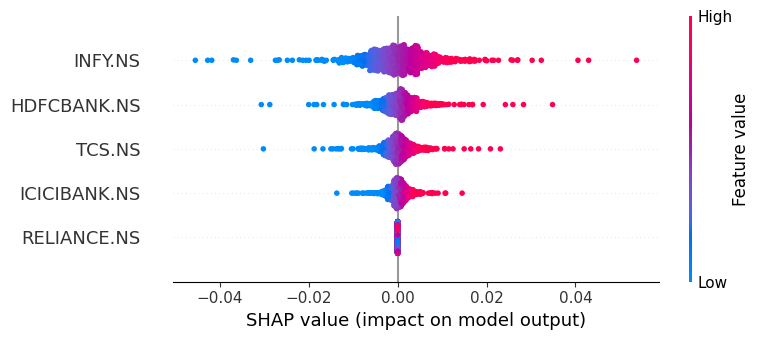

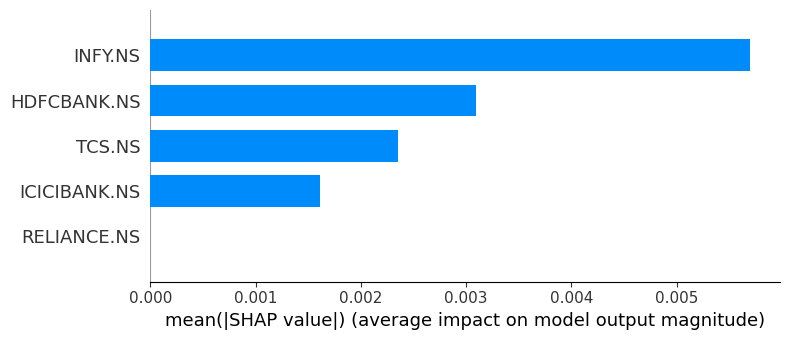

In [12]:
# Explainable AI (XAI) using SHAP
explainer = shap.Explainer(lambda x: np.dot(x, optimal_weights), returns.values)
shap_values = explainer(returns.values)
plt.figure(figsize=(10, 6))  # Adjust width and height
shap.summary_plot(shap_values, returns.values, feature_names=tickers)
shap.summary_plot(shap_values, returns.values, feature_names=tickers, plot_type = "bar")


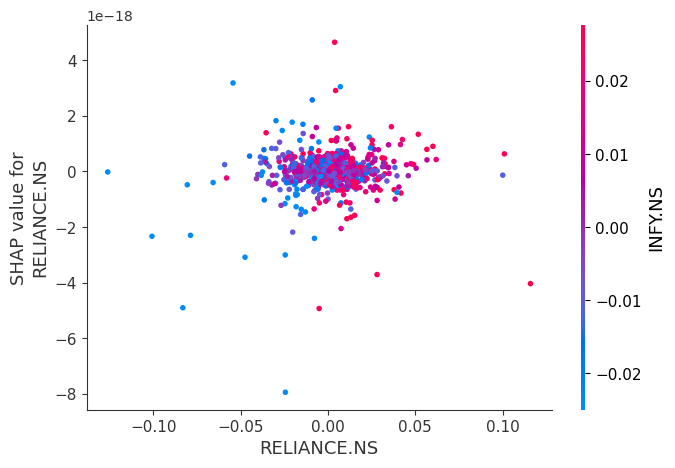

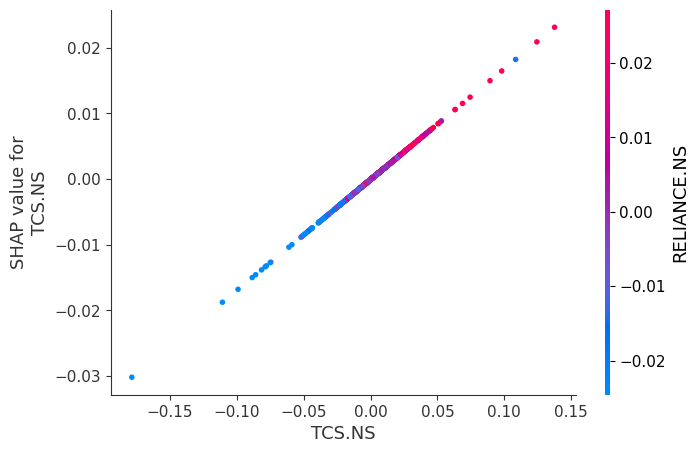

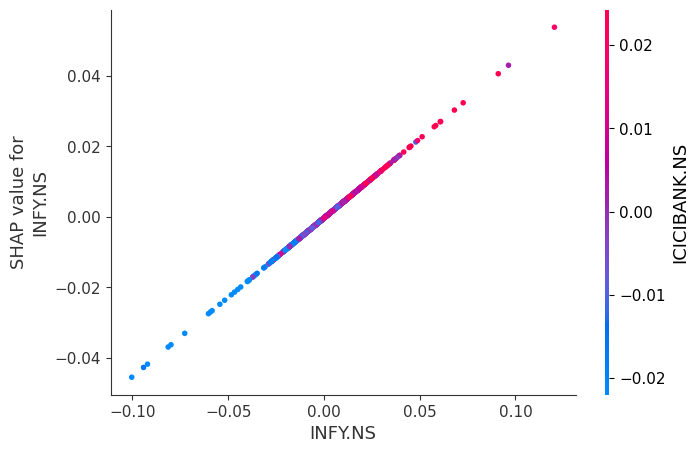

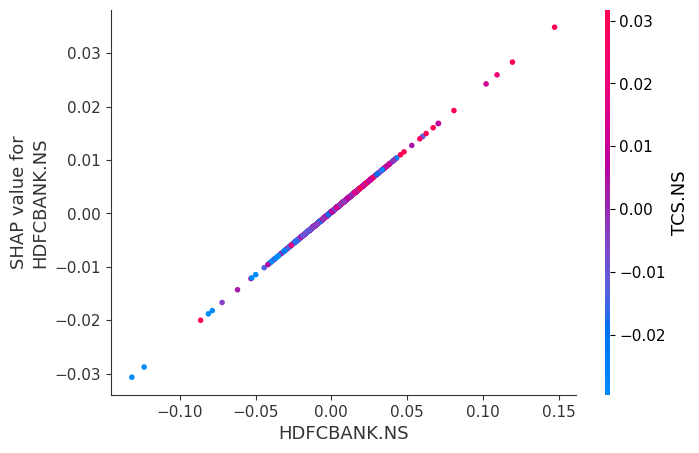

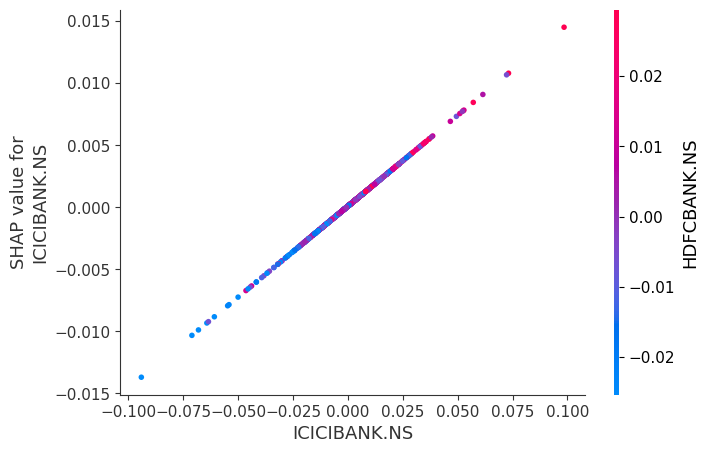

In [13]:
for i, ticker in enumerate(tickers):
    shap.dependence_plot(i, shap_values.values, returns.values, feature_names=tickers)
